## Imports & Formatting:

In [1]:
from signal_processing import pure_tone_complex, sound, magphase, get_spect, magphase
import matplotlib.pyplot as plt
from scipy.signal import spectrogram as sp
import scipy as scip
import numpy as np

#Formatting (to center plots):
from IPython.display import display, HTML
import IPython.display as ipd

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

## F0_DL Discrimination Task Stimuli:

### Idea: 
   - Testing perceptual/psychophysical properties of pitch. How does cochlear impairment impact pitch discriminability

### TODO:
   - Parameterize nicely
   - Add noise to reduce distortion products?
   - Buzziness at high frequencies...should all harmonics be same magnitude or should there be a decay?

In [2]:
from scipy import signal

def pitch_discrim(F0 = 250, shift = 1e-2, atten = 0.5, harm_rank = 3, tot_harm = 5, spacing = 0.03, dur_sec = 0.5, ramp_dur = 0.2, fs = 44100, phase = 'alt'):
    freq_Hz1 = np.arange(harm_rank,tot_harm+1)*F0;
    freq_Hz2 = freq_Hz1*(1+shift);
    mags = np.ones(len(freq_Hz1))*freq_Hz1**-1.3;

    #exponentially drop harmonic mags
    #mags = atten*np.ones(len(freq_Hz1))*np.exp(-np.arange(0,len(freq_Hz1)));

    
    if phase == 'sin':
        phi = np.zeros(len(freq_Hz1));
    else:
        phi = np.zeros(len(freq_Hz1))+np.pi/2*(np.arange(len(freq_Hz1))%2);

    space = np.zeros(round(spacing*fs));

    ham_win = np.hamming(round(dur_sec*fs*ramp_dur));
    ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((dur_sec*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);

    F_1 = pure_tone_complex(freq_Hz1, fs, dur_sec, mags, phi)
    F_2 = pure_tone_complex(freq_Hz2, fs, dur_sec, mags, phi)

    signal = np.concatenate([ham*F_1[1],space,ham*F_2[1],space,ham*F_1[1],space,ham*F_2[1]]);
    signal = atten*signal/np.max(signal);

    time = np.arange(0,dur_sec*4,1/fs);

    return signal, time;




#Harmonic Frequency Modulation:
def hfm(F0 = 250, a_mod = 100, rate_mod = 1, harm_rank = 3, tot_harm = 15, dur_sec = 5, atten = 0.3, fs = 44100, ramp_dur = 0.2, phase = 'sin', noise_on = False, noise_cutoff = 21e2, noise_atten = 0.02):
    samples = np.arange(0,fs*dur_sec);
    time_sec = samples/fs;
    harm_no = np.arange(harm_rank,tot_harm+1);
    mags = atten*np.ones(len(harm_no));

    #[OPTIONAL] decay to reduce buzziness
    mags = np.ones(len(harm_no))*(F0*harm_no)**-1.3;
    mags = atten*mags/mags[0];
    
    if phase == 'sin':
        phi = np.zeros(len(harm_no));
    else:
        phi = np.zeros(len(harm_no))+np.pi/2*(harm_no%2);  
        
    for i in range(len(harm_no)):
        amp_mod = a_mod*(harm_no[i]);
        F0_temp = F0*harm_no[i];
        mod = amp_mod*np.sin(2*np.pi*rate_mod*time_sec + np.pi);
        sig_temp = mags[i]*np.sin(2*np.pi*F0_temp*time_sec + mod/rate_mod + phi[i]);
        #sig_temp = mags[i]*np.sin(2*np.pi*F0_temp*time_sec + mod/rate_mod);
        
        sig_arr = np.array(sig_temp)

        if i==0:
            sig = sig_arr;
        else:
            sig = sig + sig_arr;
    
    if noise_on == True:
        noise_bb = np.random.normal(0,noise_atten,size = len(sig));
        sos = signal.butter(4, noise_cutoff, 'lp', fs=fs, output = 'sos');
        noise = signal.sosfilt(sos, noise_bb);
        sig = sig + noise;
    
    #ramp
    ham_win = np.hamming(round(dur_sec*fs*ramp_dur));
    ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((dur_sec*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);        
    sig = ham*sig;
    
    return sig, time_sec;

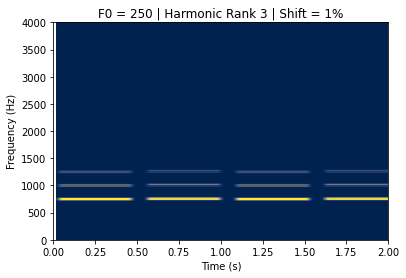

In [10]:
F0 = 250;
shift = .3e-2;
harm_rank = 16;
tot_harm = 18;

fs = round(50e6/1024);
atten = .5;
spacing = .03;
dur_sec = .5;
ramp_dur = 0.2;

###################################################################################################################
sig, time = pitch_discrim(F0 = 250, fs = fs);
get_spect(sig, fs, DR = 30, BW = 100, xlim = [0,2], ylim = [0,4e3], 
          colormap = 'cividis', title = 'F0 = 250 | Harmonic Rank 3 | Shift = 1%');
sound(sig,fs,fname = 'blah.wav', savefile = 1)
#ipd.Audio(sig, rate = fs)


## FM Harmonic Tone Complex Stimuli:
### Idea: 
   - Not a directly perceptual measure, ideally directly correlates with pitch coding
   - Won't be measuring FFR at discrete frequencies, rather measures the ability to track a moving pitch with varying harmonic rank. Could also add masking. 
   - See if Dave Axe's FFR findings in carbo chins (i.e. poorer FM coding) extend to pitch stimuli

### TODO:
   - Same as above
   - Math check...basic trig 
   - Spectrogram auto-title

/mnt/20D22780D22758F4/Shared/Code/Python_Coding_Toolbox/signal_processing/pitch/signal_processing.py:268: UserWarning: shading value 'goraud' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(t,f,Sgram_dB, shading = shading, cmap = colormap);


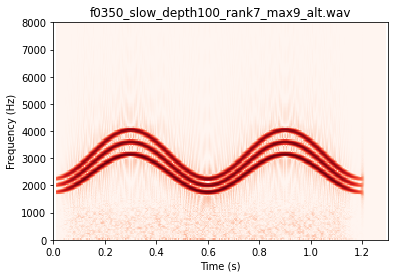

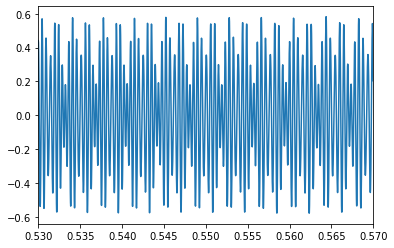

In [31]:
%matplotlib inline

F0 = 350;
a_mod = 100;
rate_mod = 1/.6;
speed = 'slow';
harm_rank = 7;
tot_harm = 9;
fs = round(50e6/1024);
dur_sec = 1.2;
atten = .3;
offset = 100e-3;
phs = 'alt';

signal2, time2 = hfm(F0 = F0, atten = atten, tot_harm = tot_harm, phase = phs,
                     a_mod = a_mod, harm_rank = harm_rank, fs = fs, 
                     rate_mod = rate_mod, dur_sec = dur_sec, ramp_dur = 0.2, 
                     noise_on = True, noise_atten = 0.05*atten, noise_cutoff = 3*F0)

pause = np.zeros(round(offset*fs));
sig2 = np.concatenate([signal2,pause]);
time = np.arange(0,len(sig2)/fs,1/fs);

fname = 'f0' + str(F0) + '_' + speed + '_depth' + str(a_mod) + '_rank' + str(harm_rank) + '_max' + str(tot_harm) + '_' + phs + '.wav';
get_spect(sig2, fs, DR = 260, BW = 200, xlim = [0,1.3], ylim = [0,8e3], 
           colormap = 'Reds', title = fname);

plt.figure()
plt.plot(time,sig2)
plt.xlim([.53,.57])


sound(sig2,fs,fname = fname, savefile = 1)
#ipd.Audio(sig2, rate = fs)